## Import Libraries ##

In [1]:
!pip install transformers

     |████████████████████████████████| 2.5MB 7.6MB/s 
     |████████████████████████████████| 901kB 48.0MB/s 
     |████████████████████████████████| 3.3MB 46.6MB/s 


In [2]:
import ast
import matplotlib.pyplot as plt
import pandas as pd
import torch

from torchtext.legacy.data import Field, TabularDataset, BucketIterator, Iterator

import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification

import torch.optim as optim

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## Preparing the Dataset ##

In [ ]:
csv_raw = pd.read_csv('finegrained_train_data.csv').drop("Unnamed: 0", axis=1)
csv_raw

,movie,genre,text
0,100earthquake,['disaster'],"Come on, Hicks. This is for your all-time best..."
1,100earthquake,['disaster'],yours? I don't know which way you're facing! I...
2,100earthquake,['disaster'],and I would appreciate not being cut out of it...
3,100earthquake,['disaster'],haven't seen last night's seismographs. I have...
4,100earthquake,['disaster'],have firearms? -No. -Of course not! Fireworks?...
...,...,...,...
3328,voyagers,['scifi'],it the alien? It was Christopher. (BREATHING H...
3329,voyagers,['scifi'],GRUNTING) (ALL CLAMORING) Grab him. Get off me...
3330,voyagers,['scifi'],Shut up. CREW MEMBERS: Shut up. Shut up. Shut ...
3331,voyagers,['scifi'],released. (DRAMATIC MUSIC PLAYING) (SELA AND Z...


In [ ]:
train_raw = csv_raw[['genre', 'text']]
train_raw.columns = ['label', 'text']
train_raw['label'] = train_raw['label'].apply(lambda x: "-".join(list(ast.literal_eval(x))))
train_raw

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,label,text
0,disaster,"Come on, Hicks. This is for your all-time best..."
1,disaster,yours? I don't know which way you're facing! I...
2,disaster,and I would appreciate not being cut out of it...
3,disaster,haven't seen last night's seismographs. I have...
4,disaster,have firearms? -No. -Of course not! Fireworks?...
...,...,...
3328,scifi,it the alien? It was Christopher. (BREATHING H...
3329,scifi,GRUNTING) (ALL CLAMORING) Grab him. Get off me...
3330,scifi,Shut up. CREW MEMBERS: Shut up. Shut up. Shut ...
3331,scifi,released. (DRAMATIC MUSIC PLAYING) (SELA AND Z...


In [ ]:
labels = {l:i for i, l in enumerate(train_raw['label'].unique())}

train_raw['label'] = train_raw['label'].apply(lambda x: labels[x])
train_raw

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,label,text
0,0,"Come on, Hicks. This is for your all-time best..."
1,0,yours? I don't know which way you're facing! I...
2,0,and I would appreciate not being cut out of it...
3,0,haven't seen last night's seismographs. I have...
4,0,have firearms? -No. -Of course not! Fireworks?...
...,...,...
3328,19,it the alien? It was Christopher. (BREATHING H...
3329,19,GRUNTING) (ALL CLAMORING) Grab him. Get off me...
3330,19,Shut up. CREW MEMBERS: Shut up. Shut up. Shut ...
3331,19,released. (DRAMATIC MUSIC PLAYING) (SELA AND Z...


In [ ]:
labels

{'action': 15,
 'action-adventure': 13,
 'action-comedy': 9,
 'action-horror': 11,
 'action-martialarts': 20,
 'action-scifi': 4,
 'action-spy': 8,
 'adventure': 3,
 'adventure-comedy': 2,
 'comedy': 18,
 'comedy-horror': 17,
 'comedy-martialarts': 12,
 'comedy-romance': 10,
 'comedy-scifi': 7,
 'comedy-spy': 16,
 'disaster': 0,
 'disaster-scifi': 1,
 'horror': 21,
 'horror-scifi': 5,
 'romance': 6,
 'romance-scifi': 14,
 'scifi': 19}

In [ ]:
train_raw.to_csv("loadtrain.csv", index=False)

## BERT Settings ##

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

MAX_SEQ_LEN = 512
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

label_field = Field(sequential=False,
                    use_vocab=False,
                    batch_first=True,
                    dtype=torch.float
                   )
text_field = Field(use_vocab=False,
                   tokenize=tokenizer.encode,
                   lower=False,
                   include_lengths=False,
                   batch_first=True,
                   fix_length=MAX_SEQ_LEN,
                   pad_token=PAD_INDEX,
                   unk_token=UNK_INDEX
                  )

fields = [
    ('label', label_field),
    ('text', text_field)
]

In [ ]:
td = TabularDataset(path='loadtrain.csv',
                    format="CSV",
                    fields=fields,
                    skip_header=True
                   )

train_td, valid_td, test_td = td.split(split_ratio=[0.7, 0.2, 0.1],
                              stratified=True,
                              strata_field='label'
                             )

Token indices sequence length is longer than the specified maximum sequence length for this model (546 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
print(len(train_td))
print(len(valid_td))
print(len(test_td))

2333
334
666


In [ ]:
batch_size = 4

train_iter = BucketIterator(train_td,
                            batch_size=batch_size,
                            device=device,
                            train=True
                           )

valid_iter = BucketIterator(valid_td,
                            batch_size=batch_size,
                            device=device,
                            train=True
                           )

test_iter = Iterator(test_td,
                     batch_size=batch_size,
                     device=device,
                     train=False,
                     shuffle=False,
                     sort=False
                    )

## Building the Model ##

In [5]:
class BERT(nn.Module):
    def __init__(self):
        super(BERT, self).__init__()
        self.encoder = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(labels))
        
    def forward(self, text, label):
        loss, text_feature = self.encoder(text, labels=label)[:2]
        return loss, text_feature

## Training ##

In [ ]:
# Save and Load Functions

def save_checkpoint(save_path, model, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model):
    
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [ ]:
len(train_iter)

584

In [ ]:
# Training Function

def train(model,
          optimizer,
          criterion = nn.CrossEntropyLoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 10,
          eval_every = len(train_iter) // 10,
          file_path = "training_output",
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for (label, text), _ in train_loader:
            label = label.type(torch.LongTensor)
            label = label.to(device)
            text = text.type(torch.LongTensor)
            text = text.to(device)
            output = model(text, label)
            loss, _ = output
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    

                    # validation loop
                    for (label, text), _ in valid_loader:
                        label = label.type(torch.LongTensor)
                        label = label.to(device)
                        text = text.type(torch.LongTensor)
                        text = text.to(device)
                        output = model(text, label)
                        loss, _ = output
                        
                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/' + 'model.pt', model, best_valid_loss)
                    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
                        
    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

model = BERT().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-5)

train(model=model, optimizer=optimizer)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch [1/10], Step [58/5840], Train Loss: 3.1058, Valid Loss: 3.0806
Model saved to ==> training_output/model.pt
Model saved to ==> training_output/metrics.pt
Epoch [1/10], Step [116/5840], Train Loss: 3.1007, Valid Loss: 3.0634
Model saved to ==> training_output/model.pt
Model saved to ==> training_output/metrics.pt
Epoch [1/10], Step [174/5840], Train Loss: 3.0569, Valid Loss: 3.0178
Model saved to ==> training_output/model.pt
Model saved to ==> training_output/metrics.pt
Epoch [1/10], Step [232/5840], Train Loss: 3.0601, Valid Loss: 2.9695
Model saved to ==> training_output/model.pt
Model saved to ==> training_output/metrics.pt
Epoch [1/10], Step [290/5840], Train Loss: 2.9502, Valid Loss: 2.8039
Model saved to ==> training_output/model.pt
Model saved to ==> training_output/metrics.pt
Epoch [1/10], Step [348/5840], Train Loss: 2.8606, Valid Loss: 2.7820
Model saved to ==> training_output/model.pt
Model saved to ==> training_output/metrics.pt
Epoch [1/10], Step [406/5840], Train Loss

In [7]:
model = BERT().to()
model.summary()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

AttributeError: ignored

Model loaded from <== training_output/metrics.pt


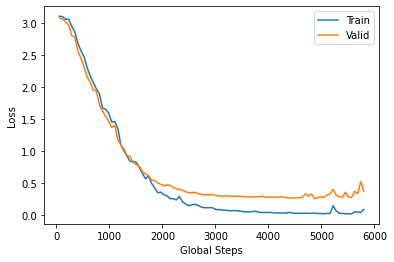

In [ ]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics("training_output" + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded from <== training_output/model.pt
Classification Report:
              precision    recall  f1-score   support

          21     0.9474    0.9474    0.9474        19
          20     1.0000    1.0000    1.0000        22
          19     1.0000    1.0000    1.0000        25
          18     0.9556    0.9348    0.9451        46
          17     1.0000    1.0000    1.0000        34
          16     0.9394    0.9394    0.9394        33
          15     1.0000    0.7826    0.8780        23
          14     0.9355    0.9667    0.9508        30
          13     1.0000    0.9259    0.9615        27
          12     1.0000    1.0000    1.0000        26
          11     1.0000    1.0000    1.0000        26
          10     0.8837    0.9500    0.9157        40
           9     0.8269    0.9773    0.8958        44
           8     0.9355    1.0000    0.9667        29
           7     0.9500    0.9500    0.9500        40
           6     0.9655    0.8235    0.8889        34
           

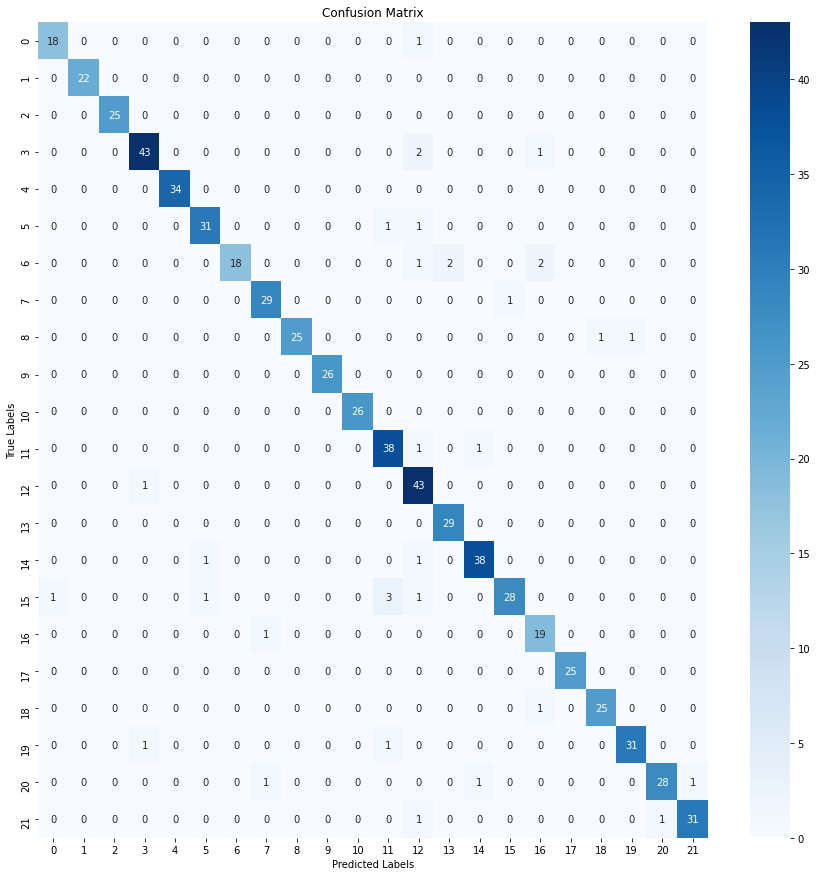

In [ ]:
def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (label, text), _ in test_loader:
                label = label.type(torch.LongTensor)           
                label = label.to(device)
                text = text.type(torch.LongTensor)  
                text = text.to(device)
                output = model(text, label)

                _, output = output
                y_pred.extend(torch.argmax(output, 1).tolist())
                y_true.extend(label.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[i for i in range(len(labels) - 1, -1, -1)], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[i for i in range(len(labels) - 1, -1, -1)])

    plt.figure(figsize = (15, 15))
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    #ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
    #ax.yaxis.set_ticklabels(['FAKE', 'REAL'])
    
best_model = BERT().to(device)

load_checkpoint("training_output" + '/model.pt', best_model)

evaluate(best_model, test_iter)